In [2]:
from qiskit_qec.circuits.repetition_code import ArcCircuit
from qiskit_qec.decoders import UnionFindDecoder
from qiskit_aer import AerSimulator, noise

import numpy as np
from scipy.stats import linregress
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})






Let's make ourselves a nice 2D ARC. For the one below, the links and schedule are for an Eagle device.

In this notebook we look at simulations of noise in ARCs with the following simple noise model.

In [3]:
def get_noise_model(p):
    p_1, p_2, p_m = p,p,p
    e_1 = noise.depolarizing_error(p_1, 1)
    e_2 = noise.depolarizing_error(p_2, 2)
    e_m = noise.pauli_error([('X',p_m),('I',1-p_m)])
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(e_1, ['h', 'x', 'rz', 'sx'])
    noise_model.add_all_qubit_quantum_error(e_2, ['cx'])
    noise_model.add_all_qubit_quantum_error(e_m, ['measure'])
    return noise_model

We'll use 2D ARCs defined on Eagle devices with 10 syndrome measurement rounds, as defined below.

In [4]:
T = 10
links = [(0, 1, 2), (2, 3, 4), (4, 5, 6), (6, 7, 8), (8, 9, 10), (10, 11, 12), (0, 14, 18), (4, 15, 22), (8, 16, 26), (12, 17, 30), (18, 19, 20), (20, 21, 22), (22, 23, 24), (24, 25, 26), (26, 27, 28), (28, 29, 30), (30, 31, 32), (20, 33, 39), (24, 34, 43), (28, 35, 47), (32, 36, 51), (37, 38, 39), (39, 40, 41), (41, 42, 43), (43, 44, 45), (45, 46, 47), (47, 48, 49), (49, 50, 51), (37, 52, 56), (41, 53, 60), (45, 54, 64), (49, 55, 68), (56, 57, 58), (58, 59, 60), (60, 61, 62), (62, 63, 64), (64, 65, 66), (66, 67, 68), (68, 69, 70), (58, 71, 77), (62, 72, 81), (66, 73, 85), (70, 74, 89), (75, 76, 77), (77, 78, 79), (79, 80, 81), (81, 82, 83), (83, 84, 85), (85, 86, 87), (87, 88, 89), (75, 90, 94), (79, 91, 98), (83, 92, 102), (87, 93, 106), (94, 95, 96), (96, 97, 98), (98, 99, 100), (100, 101, 102), (102, 103, 104), (104, 105, 106), (106, 107, 108), (96, 109, 114), (100, 110, 118), (104, 111, 122), (108, 112, 126), (114, 115, 116), (116, 117, 118), (118, 119, 120), (120, 121, 122), (122, 123, 124), (124, 125, 126)]
schedule = [[(0, 14), (2, 3), (4, 15), (6, 7), (8, 16), (10, 11), (12, 17), (18, 19), (22, 23), (26, 27), (30, 31), (20, 33), (24, 34), (28, 35), (32, 36), (39, 40), (43, 44), (47, 48), (37, 52), (41, 53), (45, 54), (49, 55), (56, 57), (60, 61), (64, 65), (68, 69), (58, 71), (62, 72), (66, 73), (70, 74), (77, 78), (81, 82), (85, 86), (75, 90), (79, 91), (83, 92), (87, 93), (94, 95), (98, 99), (102, 103), (106, 107), (96, 109), (100, 110), (104, 111), (108, 112), (114, 115), (118, 119), (122, 123)], [(0, 1), (4, 5), (8, 9), (18, 14), (22, 15), (26, 16), (30, 17), (20, 21), (24, 25), (28, 29), (39, 33), (43, 34), (47, 35), (51, 36), (37, 38), (41, 42), (45, 46), (49, 50), (56, 52), (60, 53), (64, 54), (68, 55), (58, 59), (62, 63), (66, 67), (77, 71), (81, 72), (85, 73), (89, 74), (75, 76), (79, 80), (83, 84), (87, 88), (94, 90), (98, 91), (102, 92), (106, 93), (96, 97), (100, 101), (104, 105), (114, 109), (118, 110), (122, 111), (126, 112), (116, 117), (120, 121), (124, 125)], [(2, 1), (4, 3), (6, 5), (8, 7), (10, 9), (12, 11), (22, 21), (26, 25), (30, 29), (20, 19), (24, 23), (28, 27), (32, 31), (39, 38), (43, 42), (47, 46), (51, 50), (41, 40), (45, 44), (49, 48), (60, 59), (64, 63), (68, 67), (58, 57), (62, 61), (66, 65), (70, 69), (77, 76), (81, 80), (85, 84), (89, 88), (79, 78), (83, 82), (87, 86), (98, 97), (102, 101), (106, 105), (96, 95), (100, 99), (104, 103), (108, 107), (118, 117), (122, 121), (126, 125), (116, 115), (120, 119), (124, 123)]]

code = {}
circuits = []
for logical in ['0', '1']:
        code[logical] = ArcCircuit(links,T,schedule=schedule,run_202=False,basis='zx',logical=logical,resets=True)
        circuit = code[logical].circuit
        for basis in [code[logical].basis, code[logical].basis[::-1]]:
            circuits.append(circuit[basis])

The decoder will be the standard Qiskit QEC Union Find.

In [5]:
decoder = UnionFindDecoder(code['0'], use_peeling=False)

To produce results, add the values of the physical error probability desired to the list `ps`.

In [7]:
ps = [0.05,0.06,0.07,0.08,0.09]
shots = 1000

for p in ps:
    print(p)
    
    job = AerSimulator().run(circuits, noise_model = get_noise_model(p), shots=shots)
    counts = [job.result().get_counts(j) for j in range(4)]

    node_nums = {}
    flat_node_nums = {}
    error_nums = {}
    log_counts = []

    all_nodes = decoder.decoding_graph.graph.nodes()
    for j in range(4):
        shots = 0
        log_counts.append({})
        for string in counts[j]:

            clusters = decoder.cluster(code[str(j%2)].string2nodes(string, all_logicals=True))
            clustered_nodes = {}
            for n, c in clusters.items():
                node = all_nodes[n]
                if not node.is_boundary:
                    if c in clustered_nodes:
                        clustered_nodes[c].append(node)
                    else:
                        clustered_nodes[c] = [node]
            for c, nodes in clustered_nodes.items():
                node_num = len(nodes)
                flat_node_num = len(code[str(j%2)].flatten_nodes(nodes))
                _, _, error_num = code[str(j%2)].check_nodes(nodes, minimal=True)
                for num, nums in [(node_num, node_nums), (flat_node_num, flat_node_nums), (error_num, error_nums)]:
                    if num in nums:
                        nums[num] += counts[j][string]/4
                    else:
                        nums[num] = counts[j][string]/4

            logical = str(decoder.get_corrections(string, clusters)[0])
            if logical in log_counts[j]:
                log_counts[j][logical] += counts[j][string]
            else:
                log_counts[j][logical] = counts[j][string]

            shots += counts[j][string]

    print('Logical counts:', log_counts)
    print('Error nums:', error_nums)

0.05
Logical counts: [{'0': 997, '1': 3}, {'0': 998, '1': 2}, {'1': 1000}, {'1': 999, '0': 1}]
Error nums: {1: 25165.5, 0: 12477.5, 2: 2240.75, 3: 1032.0, 6: 169.5, 4: 491.5, 11: 18.0, 5: 272.0, 10: 32.75, 15: 6.25, 9: 38.25, 7: 98.25, 12: 10.75, 8: 74.25, 17: 3.25, 21: 1.0, 14: 8.75, 13: 10.0, 20: 1.5, 22: 0.5, 19: 1.0, 18: 2.75, 16: 2.25, 24: 0.25, 23: 0.5}
0.06
Logical counts: [{'0': 986, '1': 14}, {'0': 980, '1': 20}, {'1': 986, '0': 14}, {'1': 985, '0': 15}]
Error nums: {1: 23341.0, 0: 11068.75, 4: 529.25, 2: 2149.75, 3: 1077.0, 8: 121.0, 5: 347.75, 6: 222.0, 7: 145.25, 9: 77.75, 12: 36.25, 21: 4.5, 10: 60.0, 25: 3.75, 11: 44.25, 15: 21.25, 17: 13.0, 13: 23.75, 14: 22.0, 20: 6.0, 19: 8.75, 22: 4.75, 16: 16.0, 23: 4.25, 18: 9.75, 24: 2.5}
0.07
Logical counts: [{'0': 945, '1': 55}, {'0': 951, '1': 49}, {'0': 69, '1': 931}, {'1': 943, '0': 57}]
Error nums: {1: 21474.25, 4: 535.75, 0: 9450.0, 2: 1949.25, 9: 104.25, 3: 1044.5, 14: 36.0, 8: 135.5, 6: 237.75, 7: 180.5, 5: 355.25, 11: 65.

Here are some previously obtained logical results.

In [6]:
# Eagle
# shots = 10000 up to 0.03, then 1000
all_logicals = {
    0.025: [{'0': 10000}, {'0': 10000}, {'1': 10000}, {'1': 10000}],
    0.026: [{'0': 10000}, {'0': 10000}, {'1': 10000}, {'1': 10000}],
    0.027: [{'0': 10000}, {'0': 9999, '1': 1}, {'1': 9998, '0': 2}, {'1': 10000}],
    0.028: [{'0': 9999, '1': 1}, {'0': 9999, '1': 1}, {'1': 9998, '0': 2}, {'1': 10000}],
    0.029: [{'0': 9998, '1': 2}, {'0': 10000}, {'1': 9998, '0': 2}, {'1': 10000}],
    0.03: [{'0': 9997, '1': 3}, {'0': 9999, '1': 1}, {'1': 9999, '0': 1}, {'1': 9991, '0': 9}],
    0.0325: [{'0': 999, '1': 1}, {'0': 1000}, {'1': 1000}, {'1': 998, '0': 2}],
    0.035: [{'0': 999, '1': 1}, {'0': 997, '1': 3}, {'1': 999, '0': 1}, {'1': 1000}],
    0.0375: [{'0': 996, '1': 4}, {'0': 993, '1': 7}, {'1': 997, '0': 3}, {'1': 994, '0': 6}],
    0.04: [{'0': 992, '1': 8}, {'0': 994, '1': 6}, {'0': 6, '1': 994}, {'1': 997, '0': 3}],
    0.0425: [{'0': 982, '1': 18}, {'0': 972, '1': 28}, {'1': 979, '0': 21}, {'1': 987, '0': 13}],
    0.045: [{'0': 977, '1': 23}, {'0': 963, '1': 37}, {'1': 971, '0': 29}, {'1': 968, '0': 32}],
    0.0475: [{'0': 972, '1': 28}, {'0': 963, '1': 37}, {'1': 966, '0': 34}, {'1': 962, '0': 38}],
    0.05: [{'0': 945, '1': 55}, {'0': 960, '1': 40}, {'1': 939, '0': 61}, {'1': 940, '0': 60}],
    0.0525: [{'0': 922, '1': 78}, {'0': 937, '1': 63}, {'1': 933, '0': 67}, {'1': 922, '0': 78}],
    0.055: [{'0': 908, '1': 92}, {'0': 922, '1': 78}, {'1': 903, '0': 97}, {'1': 871, '0': 129}],
    0.0575: [{'0': 897, '1': 103}, {'1': 116, '0': 884}, {'1': 890, '0': 110}, {'1': 864, '0': 136}],
    0.06: [{'0': 867, '1': 133}, {'1': 123, '0': 877}, {'1': 842, '0': 158}, {'1': 836, '0': 164}],
    0.0625: [{'0': 823, '1': 177}, {'0': 832, '1': 168}, {'1': 806, '0': 194}, {'1': 810, '0': 190}],
    0.065: [{'0': 803, '1': 197}, {'0': 831, '1': 169}, {'1': 796, '0': 204}, {'1': 804, '0': 196}],
    0.0675: [{'0': 791, '1': 209}, {'1': 216, '0': 784}, {'1': 780, '0': 220}, {'1': 767, '0': 233}],
    0.07: [{'0': 754, '1': 246}, {'0': 777, '1': 223}, {'0': 257, '1': 743}, {'1': 762, '0': 238}]
}

Let's plot them all

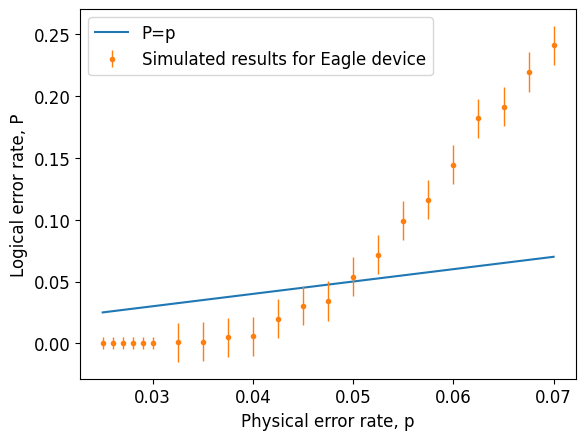

In [8]:
shots = 1000

P = {}
P_err = {}
for p in all_logicals:
    P[p] = 0
    for idx, val in [(0,'1'), (1,'1'), (2,'0'), (3,'0')]:
        if val in all_logicals[p][idx]:
            P[p] += all_logicals[p][idx][val]
    shots = 4*(sum(all_logicals[p][0].values()))
    P[p] /= shots
    P_err[p] = 1/shots**0.5

plt.ylabel('Logical error rate, P')
plt.xlabel('Physical error rate, p')

plt.plot([min(P.keys()), max(P.keys())], [min(P.keys()), max(P.keys())])
plt.errorbar(P.keys(), P.values(), yerr=list(P_err.values()), linewidth=0, elinewidth=1, marker='.')
plt.legend(['P=p', 'Simulated results for Eagle device'])

Here are some previously obtained results for the number of clusters for different sizes.

In [9]:
#shots = 100000 up to 0.005, then 10000

all_error_nums = {
    0.001: {0: 203423.0, 1: 149273.0, 2: 1133.75, 5: 0.25, 3: 29.25, 4: 1.75},
    0.002: {0: 301546.25, 1: 290596.0, 2: 4287.25, 3: 234.0, 4: 16.0, 5: 1.75},
    0.003: {0: 395219.0, 1: 426501.5, 3: 720.0, 2: 9229.0, 4: 61.75, 5: 6.0, 6: 1.0},
    0.004: {0: 481757.75, 1: 557908.5, 2: 15813.0, 3: 1557.75, 4: 199.5, 5: 25.75, 6: 5.25, 7: 0.5},
    0.005: {0: 565279.25, 1: 681465.5, 4: 450.0, 2: 23769.5, 3: 2907.5, 6: 11.0, 5: 80.5, 7: 2.5, 8: 0.25},
    0.006: {0: 64115.25, 1: 79796.5, 4: 88.75, 2: 3240.75, 3: 469.25, 5: 20.0, 6: 3.75, 7: 1.0},
    0.007: {0: 71508.5, 1: 90629.75, 3: 712.5, 2: 4267.75, 4: 149.75, 6: 6.0, 5: 34.0, 7: 1.5, 8: 0.25, 9: 0.25},
    0.008: {0: 77668.0, 1: 101267.25, 2: 5367.75, 3: 978.75, 4: 242.0, 5: 59.5, 6: 17.5, 7: 5.25, 8: 1.25, 9: 0.25},
    0.009: {0: 84325.0, 1: 110901.25, 2: 6426.75, 3: 1382.0, 4: 354.25, 5: 101.0, 6: 24.25, 7: 10.5, 8: 2.0, 9: 1.25},
    0.01: {0: 89715.5, 1: 119681.5, 2: 7618.25, 3: 1688.0, 4: 485.75, 7: 18.0, 5: 149.75, 6: 47.75, 9: 2.75, 8: 5.5, 10: 1.25, 11: 0.25},
    0.011: {0: 95408.5, 1: 128405.25, 2: 8742.5, 3: 2127.25, 5: 234.75, 4: 678.75, 7: 32.25, 8: 11.5, 6: 67.0, 9: 4.0, 10: 1.75, 13: 0.25, 11: 0.5},
    0.012: {0: 99432.75, 1: 135840.25, 3: 2549.75, 2: 9718.75, 5: 305.25, 4: 860.25, 6: 119.75, 9: 10.5, 7: 49.25, 12: 1.0, 8: 21.5, 10: 5.5, 13: 0.25, 14: 0.25},
    0.013: {0: 103933.75, 1: 143002.75, 2: 10993.25, 4: 1086.75, 3: 3004.5, 8: 35.0, 5: 421.5, 6: 171.0, 12: 2.5, 7: 77.75, 9: 15.25, 14: 0.25, 10: 7.5, 11: 2.5, 13: 0.5},
    0.014: {0: 107813.75, 1: 149279.75, 2: 11943.5, 3: 3450.25, 6: 243.0, 4: 1300.0, 5: 524.0, 7: 99.0, 8: 44.25, 9: 23.75, 10: 11.25, 12: 2.5, 18: 0.25, 14: 0.5, 11: 5.0, 13: 2.75, 16: 0.25},
    0.015: {0: 111012.75, 1: 154907.25, 2: 13022.25, 4: 1541.75, 3: 3895.5, 5: 687.75, 8: 74.5, 6: 324.5, 7: 166.0, 10: 19.0, 9: 41.75, 11: 9.25, 13: 1.0, 21: 0.25, 12: 5.0, 16: 0.25, 15: 0.75, 14: 1.25},
    0.016: {0: 113701.25, 1: 160012.5, 3: 4386.5, 2: 13953.5, 7: 209.5, 4: 1847.75, 8: 113.0, 5: 825.75, 6: 418.5, 11: 18.0, 9: 63.75, 12: 9.25, 10: 34.5, 15: 1.75, 13: 3.5, 16: 0.75, 14: 2.25, 18: 0.25, 19: 0.25},
    0.017: {0: 116538.5, 1: 163834.5, 2: 14748.25, 3: 4864.75, 5: 1013.0, 4: 2094.25, 8: 151.5, 7: 274.5, 6: 515.5, 10: 42.25, 9: 77.5, 13: 8.25, 11: 24.5, 14: 3.75, 12: 14.25, 15: 2.5, 17: 0.5, 16: 1.0, 18: 0.75, 21: 0.25},
    0.018: {0: 118255.5, 1: 167578.75, 2: 15595.0, 6: 648.5, 3: 5283.75, 8: 190.0, 7: 345.0, 4: 2379.75, 5: 1209.0, 9: 112.0, 10: 71.5, 11: 37.5, 13: 14.5, 14: 8.75, 12: 22.0, 18: 1.5, 15: 3.75, 17: 1.25, 16: 2.25, 19: 0.75, 21: 0.5},
    0.019: {0: 120151.0, 1: 171040.0, 2: 16254.75, 3: 5635.75, 6: 744.5, 10: 92.0, 4: 2593.5, 5: 1351.5, 11: 60.25, 8: 254.0, 7: 419.75, 9: 151.0, 13: 22.5, 12: 33.0, 20: 0.75, 14: 11.5, 16: 4.25, 15: 9.0, 18: 0.75, 17: 2.75, 19: 0.25},
    0.02: {0: 121258.0, 1: 173586.25, 2: 16817.5, 3: 6014.5, 4: 2865.5, 6: 861.0, 5: 1528.5, 8: 311.5, 7: 535.0, 9: 205.25, 10: 129.0, 13: 31.25, 12: 56.0, 11: 78.25, 14: 20.0, 17: 3.5, 15: 12.25, 16: 10.25, 19: 1.0, 24: 0.5, 18: 2.75, 21: 0.25, 20: 0.25},
    0.021: {0: 122241.5, 1: 175362.0, 2: 17269.0, 3: 6330.5, 6: 956.0, 4: 3075.25, 5: 1685.5, 12: 68.75, 11: 115.5, 8: 389.75, 10: 168.5, 7: 622.5, 9: 262.5, 17: 6.75, 15: 23.0, 13: 49.0, 14: 34.75, 20: 2.5, 16: 12.75, 19: 2.25, 18: 3.0, 22: 0.25, 26: 0.25, 21: 0.75},
    0.022: {0: 122503.75, 1: 176426.0, 2: 17648.25, 16: 20.5, 8: 471.25, 5: 1820.0, 3: 6612.25, 4: 3305.25, 6: 1124.75, 7: 747.0, 10: 223.25, 9: 336.25, 12: 101.5, 14: 47.75, 11: 143.25, 15: 29.5, 13: 68.75, 18: 7.75, 17: 12.5, 21: 1.0, 20: 2.25, 19: 5.25, 22: 0.75, 23: 0.25},
    0.023: {0: 123055.0, 1: 177647.75, 3: 6776.25, 2: 18056.75, 5: 1984.75, 4: 3504.75, 6: 1219.0, 9: 384.5, 7: 830.5, 8: 556.25, 11: 192.75, 20: 5.25, 17: 18.5, 14: 65.5, 10: 276.75, 12: 135.0, 13: 94.75, 18: 11.75, 15: 43.25, 16: 28.25, 21: 2.75, 19: 5.5, 25: 1.25, 23: 0.75, 24: 0.25, 22: 0.5},
    0.024: {0: 122713.25, 1: 177755.5, 2: 18267.5, 3: 7037.75, 4: 3548.5, 5: 2110.5, 8: 640.25, 7: 885.0, 12: 174.25, 9: 454.75, 10: 330.25, 14: 87.5, 6: 1364.75, 13: 109.0, 11: 236.75, 17: 28.75, 15: 60.5, 19: 14.25, 18: 23.25, 16: 43.0, 20: 6.75, 22: 3.5, 21: 2.5, 23: 2.75, 27: 0.25, 24: 0.25},
    0.025: {0: 122274.25, 1: 177758.0, 2: 18168.5, 3: 7095.75, 8: 710.25, 4: 3771.25, 9: 522.75, 14: 118.0, 13: 170.0, 6: 1468.5, 5: 2212.0, 7: 1007.0, 10: 396.5, 15: 91.25, 12: 232.5, 11: 315.5, 17: 42.75, 18: 24.75, 16: 56.0, 19: 19.75, 20: 11.0, 22: 5.0, 24: 1.25, 21: 5.75, 25: 1.0, 23: 1.0, 26: 0.25},
    0.026: {0: 121784.75, 1: 177685.75, 2: 18352.0, 5: 2311.5, 4: 3833.75, 3: 7216.25, 9: 597.0, 16: 90.5, 8: 765.5, 6: 1564.75, 15: 120.25, 7: 1066.5, 20: 14.5, 10: 437.5, 13: 197.75, 11: 343.75, 12: 260.5, 14: 148.0, 17: 60.0, 18: 35.5, 21: 12.0, 22: 5.5, 19: 25.0, 23: 4.75, 24: 3.0, 27: 0.25, 25: 0.5},
    0.027: {1: 176353.75, 0: 121036.25, 2: 18139.0, 6: 1617.0, 3: 7178.0, 4: 3857.75, 10: 506.5, 5: 2297.25, 7: 1153.5, 11: 403.75, 8: 876.5, 14: 188.25, 15: 148.5, 12: 318.0, 9: 664.0, 13: 257.25, 17: 83.25, 18: 59.75, 19: 41.0, 23: 6.5, 16: 121.75, 21: 17.5, 20: 25.25, 26: 0.75, 24: 3.0, 22: 10.75, 27: 1.5, 25: 1.75},
    0.028: {0: 119711.25, 1: 174910.75, 5: 2433.25, 3: 7200.25, 2: 18017.75, 10: 572.75, 4: 3909.75, 7: 1221.5, 12: 364.5, 17: 101.25, 6: 1630.75, 9: 710.0, 8: 916.25, 11: 454.0, 13: 307.0, 14: 230.75, 16: 142.75, 15: 191.75, 19: 60.0, 20: 40.0, 25: 3.0, 18: 81.0, 21: 30.25, 23: 7.75, 24: 5.0, 22: 15.0, 26: 1.25},
    0.029: {1: 173332.25, 0: 118595.75, 2: 17777.25, 8: 965.5, 12: 422.75, 3: 7157.0, 11: 508.25, 10: 619.5, 7: 1233.25, 6: 1631.5, 5: 2379.75, 4: 3957.25, 9: 786.0, 13: 346.5, 16: 170.5, 17: 145.5, 14: 298.0, 18: 97.5, 15: 234.75, 23: 16.5, 19: 71.75, 21: 38.0, 20: 57.25, 22: 22.0, 24: 9.5, 27: 1.5, 25: 7.0, 26: 1.5},
    0.03: {0: 116896.25, 1: 171534.5, 4: 3822.0, 3: 7013.25, 9: 779.0, 2: 17619.25, 6: 1674.25, 7: 1272.5, 5: 2470.25, 8: 986.5, 11: 559.5, 10: 651.75, 13: 406.0, 12: 509.25, 17: 185.75, 15: 274.25, 14: 340.25, 18: 138.5, 19: 106.75, 16: 222.75, 20: 69.0, 21: 53.0, 23: 25.5, 24: 10.0, 25: 6.75, 22: 32.0, 27: 1.25, 26: 5.0},    
}

Let's plot them for a chosen value of `p`.

<ErrorbarContainer object of 3 artists>

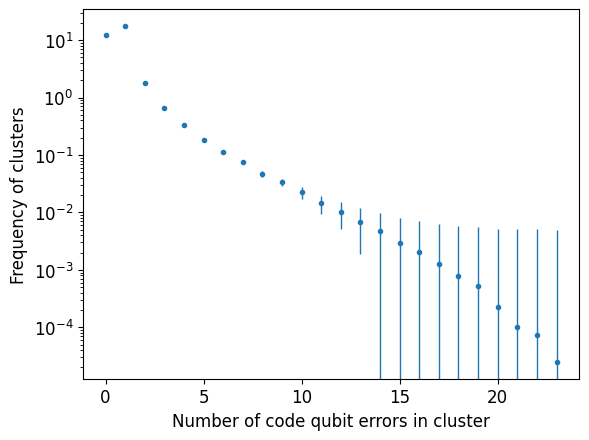

In [22]:
p = 0.022

shots = 10000

plt.ylabel('Frequency of clusters')
plt.xlabel('Number of code qubit errors in cluster')
plt.yscale("log")
xs = []
ys = []
yerrs = []
for num, cluster_num, in all_error_nums[p].items():
    xs.append(num)
    ys.append(cluster_num/shots)
    yerrs.append(1/(4*shots)**0.5)
plt.errorbar(xs, ys, yerr=yerrs, linewidth=0, elinewidth=1, marker='.')

For each `p` we can calculate the decay factor for the exponential decay, and then plot them all.

<ErrorbarContainer object of 3 artists>

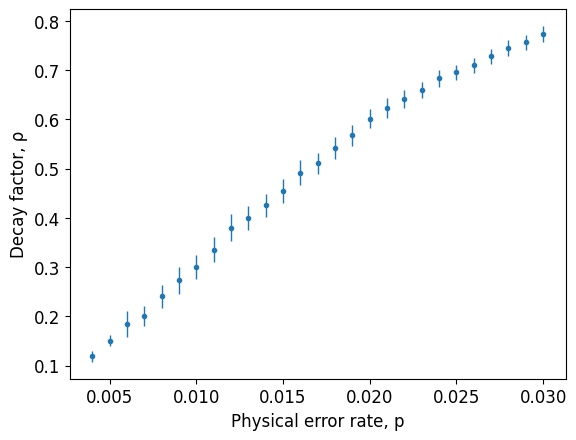

In [34]:
ps = []
rhos = []
rho_errs = []
for p, error_nums in all_error_nums.items():
    log_error_nums = {}
    for n, num in error_nums.items():
        if n>1 and num>10:
            log_error_nums[n] = np.log(num)
    line = linregress(
                list(log_error_nums.keys()),
                list(log_error_nums.values())
            )
    rho = np.exp(line.slope)
    if 2*line.stderr*rho > 0.01:
        ps.append(p)
        rhos.append(rho)
        rho_errs.append(2*max(rho*np.exp(line.stderr)-rho, rho-rho/np.exp(line.stderr)))

plt.ylabel('Decay factor, ρ')
plt.xlabel('Physical error rate, p')
plt.errorbar(ps, rhos, yerr=rho_errs, linewidth=0, elinewidth=1, marker='.')